In [1]:
import os

def import_from_directory(directory, module_name):
    current_dir = os.getcwd()
    os.chdir(directory)
    module = __import__(module_name)
    os.chdir(current_dir)
    return module

model_base = import_from_directory('/home/jovyan/work/spectrum/notebooks/src', 'model_base')

2024-05-03 03:29:56.022641: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-03 03:29:56.063009: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-03 03:29:56.063055: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-03 03:29:56.064546: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-03 03:29:56.072510: I tensorflow/core/platform/cpu_feature_guar

In [2]:
SEED = 42
model_base.set_seed(SEED)

desired_directory = '/home/jovyan/work/spectrum/notebooks/'
os.chdir(desired_directory)

In [3]:
import pandas as pd
from keras.models import load_model

In [4]:
df = pd.read_csv('Data/tabledata_all.csv')
df_neg = df[df['Adducttype'].str.contains('\]\-') | df['Adducttype'].str.contains('\]2\-')]
df_neg2 = model_base.cal_df_sel_column(df_neg)
df_neg_wide = model_base.cal_wide_df(df_neg2)

/home/jovyan/work/spectrum/notebooks/src/model_base.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'ID'] = df['datasetID'].astype(str)  + '_' + df['AlignmentID'].astype(str)


In [5]:
columnlist_path = 'Data/model_data/neg/negmodelcolumn_all.pkl'
replacement_dict_path = 'Data/model_data/neg/neg_replacement_dict_all.pkl'
y_test_path = 'Data/model_data/neg/df_neg_ytest.csv'

df_neg_wide2, X_train, X_test, X_eval, y_train, y_test, y_eval, train_d, test_d, y, replacement_dict = \
    model_base.train_test_split_from_df(df_neg_wide, columnlist_path, replacement_dict_path, y_test_path) #split data

y_train_onehot, y_test_onehot, y_eval_onehot = model_base.replace_y_onthot(y, y_train, y_test, y_eval, replacement_dict) #onehot

In [6]:
y_train_replaced0, y_test_replaced0, y_eval_replaced0 = model_base.replace_y_number(y, y_train, y_test, y_eval, replacement_dict)

ランダムフォレスト

In [7]:
rf_accuracy, rf_precision, rf_recall, rf_f1 =\
    model_base.rf_random_search(X_train, y_train_replaced0, X_test, y_test_replaced0)

  0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/lib/python3.11/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
100%|██████████| 1/1 [03:57<00:00, 237.58s/it]

best score
parameter:{'n_estimators': 300, 'max_depth': 40, 'criterion': 'gini'}
0.9448867115737906 0.8063656131119449 0.7141826593352598 0.7382039246608266



/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


SVM

In [11]:
svm_accuracy, svm_precision, svm_recall, svm_f1 =\
    model_base.svm_random_search(X_train, y_train_replaced0, X_test, y_test_replaced0)

/opt/conda/lib/python3.11/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 24 is smaller than n_iter=100. Running 24 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/site-packages/sklear

best score
parameter:{'kernel': 'linear', 'decision_function_shape': 'ovo', 'C': 5}
0.9540722596448254 0.8168071681459148 0.800862417939743 0.7936966638964436


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


knn

In [12]:
knn_accuracy, knn_precision, knn_recall, knn_f1 =\
    model_base.knn_random_search(X_train, y_train_replaced0, X_test, y_test_replaced0)

/opt/conda/lib/python3.11/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 20 is smaller than n_iter=100. Running 20 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


best score
parameter:{'weights': 'uniform', 'p': 2, 'n_neighbors': 1}
0.9271279853031231 0.7840805181688746 0.7773182131798767 0.7566701483012354


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


NN

In [13]:
model = load_model('models/neg_class_model')

In [14]:
nn_accuracy, nn_precision, nn_recall, nn_f1 =\
    model_base.nn_score_summary(model, X_test, y_test_onehot)


52/52 [==============================] - 0s 5ms/step
0.9608083282302511 0.7952789252831454 0.7902986623544479 0.7754075473774116


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


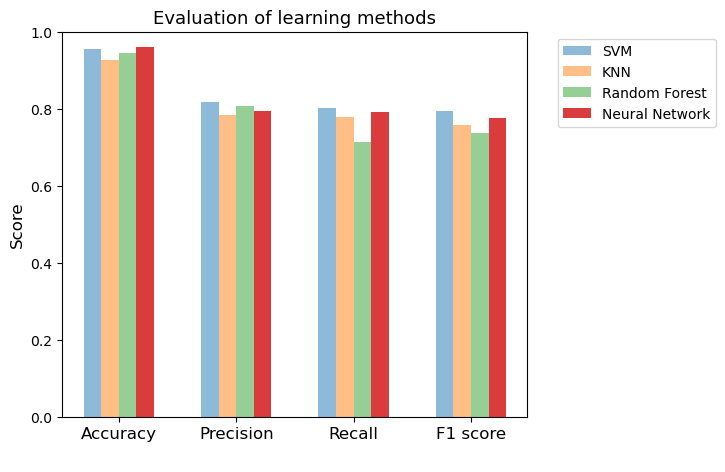

In [21]:
save_path = 'Data/model_data/neg/neg_class_model_perf.svg'
SVM = [svm_accuracy, svm_precision, svm_recall, svm_f1]
KNN = [knn_accuracy, knn_precision, knn_recall, knn_f1]
RF = [rf_accuracy, rf_precision, rf_recall, rf_f1]
NN = [nn_accuracy, nn_precision, nn_recall, nn_f1]

model_base.models_perf_plot(SVM, KNN, RF, NN, save_path)